In [1]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [2]:
# Genetic Programming constants:
POPULATION_SIZE = 2000
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 10

Set the random seed. 

In [3]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Here are some GP-specific constants. Keeping them together like this will make later editing easier.

In [4]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. One nice thing about this problem is that it is of scalable difficulty, so we name make it more difficult simply by increasing the number of inputs.

In [5]:
NUM_INPUTS = 3  # 3-bit parity problem
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [6]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = [sum(row) % 2 for row in parityIn]


# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    
    return sum(
        func(*pIn) != pOut 
        for pIn, pOut in zip(parityIn, parityOut)
    )

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

Add our functions and terminals. This time we are using Boolean operators and values.

## Primitive Set of AND, OR, XOR, NOT

In [7]:
# create the primitive set:
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)
primitiveSet.addPrimitive(operator.xor, 2)
primitiveSet.addPrimitive(operator.not_, 1)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)

Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [8]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=primitiveSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=primitiveSet)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



Set up our population as before

In [9]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [10]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


Run our GP. Notice how much slower this one is, due to the much larger population size. 

In [11]:
population, logbook1 = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    stats=mstats,
    halloffame=hof,
    verbose=True,
)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	2000  	3.9865	0  	8  	0  	2000  	0.760472	22.588	0  	60 	4  	2000  	13.2948
1  	1799  	3.8385	1  	8  	0  	1799  	0.753935	22.037	1  	69 	1  	1799  	13.1755
2  	1787  	3.758 	2  	8  	0  	1787  	0.802768	22.768	2  	81 	1  	1787  	13.8175
3  	1809  	3.7015	3  	8  	0  	1809  	0.867985	23.6285	3  	83 	1  	1809  	14.7388
4  	1816  	3.6695	4  	8  	0  	1816  	0.874797	25.051 	4  	86 	1  	1816  	15.4465
5  	1764  	3.568 	5  	8  	0  	1764  	0.972304	27.555 	5  	100	1  	1764  	16.6093
6  	1792  	3.4435	6  	8  	0  	1792  	1.05821 	30.569 	6  	100	1  	1792  	18.1468
7  	1810  	3.258 	7  	8  	0  	1810  	1.10247 	33.37  	7  	108	1  	1810  	18.9958
8  	1807  	3.157 	8  	8  	0  	1807  	1.16934 	36.724 	8  	1

Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

-- Best Individual =  xor(not_(and_(or_(in_0, in_2), and_(in_0, in_0))), or_(and_(and_(in_1, in_2), xor(0, 1)), xor(xor(in_0, or_(in_2, in_1)), not_(in_0))))
-- length=25, height=5
-- Best Fitness =  0.0


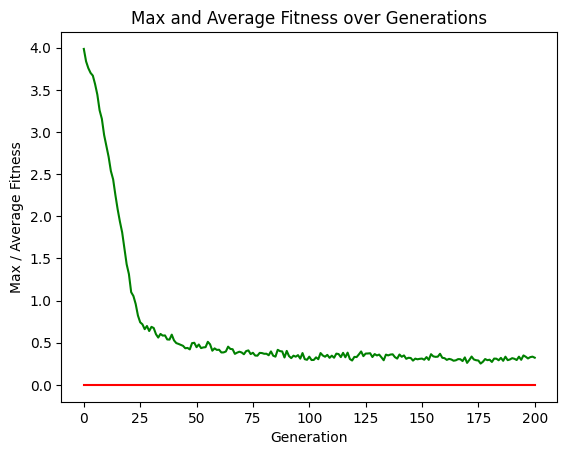

In [12]:
maxFitnessValues, meanFitnessValues = logbook1.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

## Primitive Set Of NAND, NOR, XNOR

In [13]:
def nand(a, b):
    return not (a and b)
def nor(a, b):
    return not (a or b)
def xnor(a, b):
    return not (a != b)


primitiveSet2 = gp.PrimitiveSet("main", NUM_INPUTS, "in_")

primitiveSet2.addPrimitive(nand, 2)
primitiveSet2.addPrimitive(nor, 2)
primitiveSet2.addPrimitive(xnor, 2)

primitiveSet2.addTerminal(1)
primitiveSet2.addTerminal(0)

Overide pset

In [14]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox.register("expr", gp.genFull, pset=primitiveSet2, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
toolbox.register("compile", gp.compile, pset=primitiveSet2)
toolbox.register("evaluate", getCost)

toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet2)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

/home/tu/micromamba/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/tu/micromamba/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [15]:
# run 

population = toolbox.populationCreator(n=POPULATION_SIZE)
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook2 = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    stats=mstats,
    halloffame=hof,
    verbose=True,
)


   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg  	gen	max	min	nevals	std    
0  	2000  	3.9965	0  	8  	0  	2000  	0.898047	36.44	0  	63 	15 	2000  	19.8516
1  	1796  	3.787 	1  	8  	0  	1796  	0.841208	36.08	1  	93 	1  	1796  	20.1236
2  	1792  	3.635 	2  	8  	0  	1792  	0.891502	37.425	2  	99 	1  	1792  	20.4837
3  	1826  	3.506 	3  	8  	0  	1826  	1.00248 	39.5  	3  	117	1  	1826  	21.0385
4  	1798  	3.3445	4  	8  	0  	1798  	1.03914 	42.435	4  	123	1  	1798  	21.2579
5  	1817  	3.249 	5  	8  	0  	1817  	1.11982 	44.489	5  	123	3  	1817  	21.4363
6  	1766  	3.0545	6  	8  	0  	1766  	1.18133 	47.811	6  	133	1  	1766  	21.7108
7  	1798  	2.914 	7  	8  	0  	1798  	1.24443 	50.1  	7  	135	3  	1798  	22.1448
8  	1794  	2.733 	8  	8  	0  	1794  	1.27778 	53.095	8  	147	3  	17

-- Best Individual =  nor(nor(xnor(in_2, in_0), nor(in_1, 0)), xnor(nand(1, in_2), xnor(in_1, in_0)))
-- length=15, height=3
-- Best Fitness =  0.0


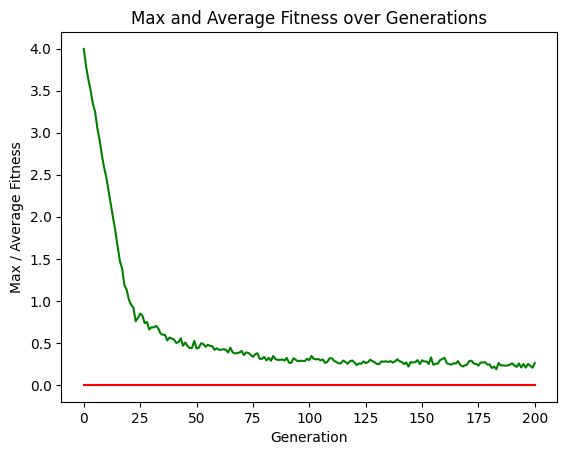

In [16]:
maxFitnessValues, meanFitnessValues = logbook2.chapters['fitness'].select("min", "avg")

# print info for best solution found:
best = hof.items[0] 
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

## Primitive Set of number operations

In [17]:
def getRemainder(a, b):
    if b == 0:
        return 1
    return a % b

primitiveSet3 = gp.PrimitiveSet("main", NUM_INPUTS, "in_")

primitiveSet3.addPrimitive(operator.add, 2)
primitiveSet3.addPrimitive(operator.sub, 2)
primitiveSet3.addPrimitive(operator.mul, 2)
primitiveSet3.addPrimitive(getRemainder, 2)

primitiveSet3.addTerminal(1)
primitiveSet3.addTerminal(0)

In [18]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox.register("expr", gp.genFull, pset=primitiveSet3, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
toolbox.register("compile", gp.compile, pset=primitiveSet3)
toolbox.register("evaluate", getCost)

toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet3)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

In [19]:
# run

population = toolbox.populationCreator(n=POPULATION_SIZE)
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook3 = algorithms.eaSimple(
    population,
    toolbox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    stats=mstats,
    halloffame=hof,
    verbose=True,
)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg 	gen	max	min	nevals	std    	avg   	gen	max	min	nevals	std    
0  	2000  	5.19	0  	8  	0  	2000  	1.41559	36.376	0  	63 	15 	2000  	20.0678
1  	1772  	4.478	1  	8  	0  	1772  	1.09659	35.396	1  	93 	5  	1772  	20.2042
2  	1796  	4.106	2  	8  	0  	1796  	0.942743	35.526	2  	101	1  	1796  	20.4071
3  	1809  	3.8915	3  	8  	0  	1809  	0.876771	36.057	3  	101	1  	1809  	21.2555
4  	1787  	3.7295	4  	8  	0  	1787  	0.955683	37.561	4  	123	1  	1787  	21.2435
5  	1802  	3.576 	5  	8  	0  	1802  	1.01253 	39.06 	5  	125	1  	1802  	21.8377
6  	1802  	3.4095	6  	8  	0  	1802  	1.07369 	41.594	6  	129	1  	1802  	22.6852
7  	1796  	3.2455	7  	8  	0  	1796  	1.1226  	44.473	7  	131	1  	1796  	23.4588
8  	1811  	3.047 	8  	8  	0  	1811  	1.22098 	47.643	8  	131	1  	1811  	23.

-- Best Individual =  getRemainder(add(getRemainder(in_1, 0), 0), sub(add(in_1, in_1), add(sub(in_1, in_0), getRemainder(in_0, in_2))))
-- length=17, height=4
-- Best Fitness =  0.0


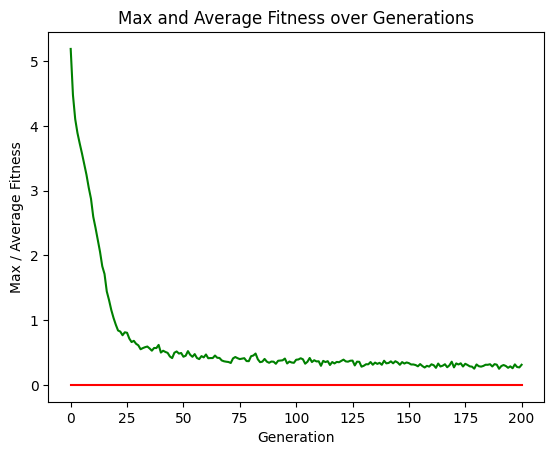

In [20]:
maxFitnessValues, meanFitnessValues = logbook3.chapters["fitness"].select("min", "avg")

# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color="red")
plt.plot(meanFitnessValues, color="green")
plt.xlabel("Generation")
plt.ylabel("Max / Average Fitness")
plt.title("Max and Average Fitness over Generations")
plt.show()

# Compare performance and the average size

In terms of performance, all primitive sets converge around the 25th generation with a fitness score of approximately 0.5. Each set reaches its best-performing individual, achieving a perfect solution, within the first few generations.

In [25]:
avgSize1 = logbook1.chapters["size"].select("avg")
avgSize2 = logbook2.chapters["size"].select("avg")
avgSize3 = logbook3.chapters["size"].select("avg")

print("Average Size each generation of AND, OR, XOR, NOT: ", avgSize1)
print("Average Size each generation of NAND, NOR, XNOR: ", avgSize2)
print("Average Size each generation of ADD, SUB, MUL, REM: ", avgSize3)

Average Size each generation of AND, OR, XOR, NOT:  [np.float64(22.588), np.float64(22.037), np.float64(22.768), np.float64(23.6285), np.float64(25.051), np.float64(27.555), np.float64(30.569), np.float64(33.37), np.float64(36.724), np.float64(39.819), np.float64(42.8885), np.float64(46.016), np.float64(49.228), np.float64(52.9055), np.float64(55.279), np.float64(57.5805), np.float64(60.2245), np.float64(62.8055), np.float64(65.039), np.float64(67.1515), np.float64(69.5805), np.float64(72.7185), np.float64(74.152), np.float64(77.578), np.float64(81.4735), np.float64(82.9045), np.float64(84.6545), np.float64(87.08), np.float64(89.3185), np.float64(90.641), np.float64(91.7125), np.float64(94.625), np.float64(98.854), np.float64(100.376), np.float64(102.689), np.float64(104.752), np.float64(106.679), np.float64(109.27), np.float64(108.8165), np.float64(108.215), np.float64(112.1085), np.float64(112.9165), np.float64(113.3715), np.float64(114.572), np.float64(115.488), np.float64(115.2175)

In [27]:
print("Average Size of AND, OR, XOR, NOT: ", numpy.mean(avgSize1))
print("Average Size of NAND, NOR, XNOR: ", numpy.mean(avgSize2))
print("Average Size of ADD, SUB, MUL, REM: ", numpy.mean(avgSize3))

print()

print("Last Generation Size of AND, OR, XOR, NOT: ", avgSize1[-1])
print("Last Generation Size of NAND, NOR, XNOR: ", avgSize2[-1])
print("Last Generation Size of ADD, SUB, MUL, REM: ", avgSize3[-1])

Average Size of AND, OR, XOR, NOT:  121.90872885572138
Average Size of NAND, NOR, XNOR:  147.74778109452737
Average Size of ADD, SUB, MUL, REM:  132.6262089552239

Last Generation Size of AND, OR, XOR, NOT:  121.3635
Last Generation Size of NAND, NOR, XNOR:  190.161
Last Generation Size of ADD, SUB, MUL, REM:  158.34
